**Môn học: Machine Learning**

**Giảng viên: **TS. Lê Thành Sách

**Bài tập lớn số 1**
: Bản hiện thực mạng CNN với numpy

*Sinh viên:*

*Nguyễn Hoàng Lộc - MSSV: 1511849*

*Nguyễn Hữu Anh Tiến - MSSV: 1513448 *

**Mô tả bài tập lớn: **Nhóm hiện thực một mạng CNN với nhiều layer khác nhau, dựa trên mô hình cấu trúc của thư viện Keras, gồm:

+ **Model chính:** class Sequential quản lí việc forward dữ liệu và backward đạo hàm quua list các layers

+ ** Các layers:** Gồm các loại như Convolution2D, MaxPooling2D, Dropout, Flatten, Dense (Fully Connected)

+ **Các hàm Activation:** Gồm hàm Relu, Sigmoid và Softmax (được chứa trong mỗi layer)

+ **Hàm Loss :** Cross Entropy (được chứa trong class Sequential)


# Install, import & setup

In [0]:
import numpy as np
import math
import numpy 
import struct
import sys
import time
import keras
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
eps = np.finfo(float).eps
from google.colab import drive

Using TensorFlow backend.


In [0]:
drive.mount('/content/drive')
sys.path.append('drive/My Drive/Colab Notebooks/') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Load data, format & visualize

In [0]:
train_images_path = 'drive/My Drive/Colab Notebooks/Asgmt_ML_CNN/data/train-images'
train_labels_path = 'drive/My Drive/Colab Notebooks/Asgmt_ML_CNN/data/train-labels'
test_images_path = 'drive/My Drive/Colab Notebooks/Asgmt_ML_CNN/data/t10k-images'
test_label_path = 'drive/My Drive/Colab Notebooks/Asgmt_ML_CNN/data/t10k-labels'


def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))       
        return numpy.fromstring(f.read(), dtype=np.uint8).reshape(shape)

def load_mnist_data():
  train_data = [read_idx(train_images_path), read_idx(train_labels_path)]
  test_data = [read_idx(test_images_path), read_idx(test_label_path)]
  return train_data, test_data

In [0]:
train_data, test_data = load_mnist_data()
X_train = train_data[0]
y_train = train_data[1]
X_test = test_data[0]
y_test = test_data[1]

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


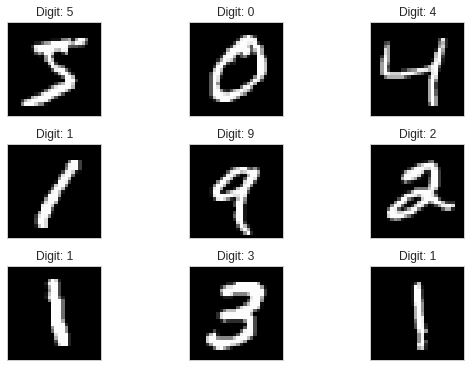

In [0]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

In [0]:
img_rows = 28
img_cols = 28
#Chuyển ảnh về format channel first
X_train_norm = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test_norm = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
input_shape = (1, img_rows, img_cols)

#Chuyển ảnh về dạng channel last
# X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
# X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
# input_shape = (img_rows, img_cols, 1)

X_train_norm = X_train_norm.astype('float32')
X_test_norm = X_test_norm.astype('float32')
X_train_norm /= 255
X_test_norm /= 255

# X_train_crop = np.array([x[0, 12:16, 12:16] for x in X_train_norm])
# X_test_crop = np.array([x[0, 12:16, 12:16] for x in X_test_norm])
# X_train_crop = X_train_crop.reshape(60000, 1, 4, 4)
#X_test_crop = X_test_crop.reshape(X_test.shape[0], 1, img_rows, img_cols)

print('X_train shape:', X_train.shape)

X_train shape: (60000, 28, 28)


In [0]:
#Chuyển tập target về dạng one-hot
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])
  
num_category = 10 #ứng với 10 label từ 0->9
y_train_norm = get_one_hot(y_train, num_category)
y_test_norm = get_one_hot(y_test, num_category)
print('y_train shape:', y_train_norm.shape)

y_train shape: (60000, 10)


# --------------------CNN - numpy inplementation--------------------

#Model - Sequential

Class Sequential đóng vai trò nắm giữ các layers, quản lí việc forward, backward

Có hiện thực các hàm evaluate, hỗ trợ predict và predict_class

In [0]:
#Class đóng vai trò là model, quản lí việc forward và backward cho các layers
class Sequential: 
  def __init__(self):
    self.layer_list = list()
    
  def add(self, new_layer):
    self.layer_list.append(new_layer)
    
  def compile(self, loss = 'cross_entropy'):
    if loss == 'cross_entropy':
      self.loss = CrossEntropy()
    else:
      pass #Có thể hiện thực thêm nhiều hàm lỗi khác
  
  def fit(self, X_train, y_train, batch_size = 128, num_epoch = 10, validation_data = None):
    self.X_train = X_train
    self.y_train = y_train
    
    train_loss_list = list()
    val_loss_list = list()
    epoch_time_list = list()

    for epoch in range(num_epoch):
      epoch_loss = list()
      for num_batch in range(X_train.shape[0] // batch_size):
        current_index = num_batch*batch_size    
        image_batch = X_train[current_index : current_index + batch_size] #Lấy các ảnh ứng với epoch
        target_batch = y_train[current_index : current_index + batch_size] #Lấy các target ứng với các ảnh

        for index, image in enumerate(image_batch):
          output = self.feed_forward(image) #Feed từng ảnh qua mạng
          self.loss.feed_forward(output, target_batch[index]) #Add ouput của layer cuối cùng vào hàm loss

        batch_avg_loss = self.loss.get_avg_loss(batch_size)
        epoch_loss.append(batch_avg_loss)
#           avg_grad = self.loss.backward(batch_size)
        avg_grad = target_batch[index]
        self.backward(avg_grad)
        self.loss.reset()
      
      epoch_avg_loss = sum(epoch_loss) / len(epoch_loss)

      train_loss_list.append(epoch_avg_loss)
      epoch_time_list.append(epoch)
      
      if validation_data is not None:
        val_loss = self.evaluate(validation_data[0], validation_data[1])
        val_loss_list.append(val_loss)
        print("Epoch ", epoch,"- Training loss: ", np.round(epoch_avg_loss, 14), " - Validating loss: ", val_loss)
      else:
        print("Epoch ", epoch,"- Training Loss: ", epoch_avg_loss)   
          
    plt.plot(epoch_time_list, train_loss_list)
    plt.plot(epoch_time_list, val_loss_list)
    plt.legend(('Train', 'Val'))
    plt.xlabel('Epoch:')
    plt.ylabel('Loss: ')
    plt.show(block=False)
       
           
  def feed_forward(self, data, isTrain = True):
    layer_input = data
    for layer in self.layer_list:
#       print('Feedforward through layer: ',type(layer)) ##
      if not isTrain and type(layer) is Dropout: #Biến isTrain để bypass layer Dropout
        continue
      layer_input = layer.feed_forward(layer_input)
#       print("Output :", np.around(layer_input, decimals = 4), layer_input.shape) ##

    #Sau khi feed qua tất cả layer thì biến layer_input chứa output của layer cuối cùng
    return layer_input 
  
  def backward(self, dY, isTrain = True):
    layer_grad = dY
    for layer in reversed(self.layer_list):
#       print('Back-forward through layer: ', type(layer)) ##
      if isTrain == False and type(layer) is Dropout:
        continue
      layer_grad = layer.backward(layer_grad)
#       print ("Output: ", np.around(layer_grad, decimals = 4), layer_grad.shape) ##
      
    
  def evaluate(self, X_test, y_test):
    output_list = list()
    for index, image in enumerate(X_test):
      output = self.feed_forward(image, isTrain = False) 
      output_list.append(output)
      self.loss.feed_forward(output, y_test[index])
    avg_loss = self.loss.get_avg_loss(len(y_test))
    self.loss.reset()
    return avg_loss
  
  def predict(self, X_test):
    output_list = list()
    for index, image in enumerate(X_test):
      output = self.feed_forward(image, isTrain = False) 
      output_onehot = np.zeros_like(output)
      output_onehot[output.argmax()] = 1
      output_list.append(output_onehot)
    return output_list

  def predict_class(self, X_test):
    output_list = self.predict(X_test)
    output_list_class = list()
    for one_hot in output_list:
      num_class,  = np.where(one_hot== 1)[0]
      output_list_class.append(num_class)
    return output_list_class

# Các hàm Activation 




## ReLu

In [0]:
class ReLU:
  def __init__(self):
    self.data = None 
    
  def feed_forward(self, data):
    data[data<0] = 0
    data = data/ (np.amax(data) + eps)
    self.data = data
    return data
  
  def backward(self, dY):
    max_data = np.amax(self.data)
    self.data[self.data>0] = 1
    return np.multiply(self.data, dY)*max_data

##Sigmoid

In [0]:
class Sigmoid:
  def __init__(self):
    self.data = None 
    
  def sigmoid(x):
    return 1 / (1 + math.exp(-x))
  
  def feed_forward(self, data):
    self.data = self.sigmoid(data)
    return data
  
  def backward(self, dY):
    return np.multiply(np.multiply(self.data, 1- self.data), dY)

## Softmax



In [0]:
class Softmax():
  def __init__(self):
    self.cache = None
  
  def feed_forward(self, X):
    self.cache = np.exp(X) / np.sum(np.exp(X), axis = 0)
    return self.cache
  
  def backward(self, dY):
    return self.cache - dY

# Hàm Loss

In [0]:
class CrossEntropy():
  def __init__(self):
    self.reset()
  
  def reset(self): #Gọi sau mỗi batch
    self.gradient = None #Chứa tổng gradient để backward cho mỗi batch
    self.total_loss = None #Chứa tổng loss của mỗi batch
    
  def feed_forward(self, output, target):
    temp = -target*(1/(np.log(2)*output))
    if self.gradient is None:
      self.gradient = temp
    else:
      self.gradient += temp 
      
    loss = np.sum(-1*target * np.log2(output + eps))
    if self.total_loss is None:
      self.total_loss = loss
    else: 
      self.total_loss += loss
      
  def get_avg_loss(self, batch_size):
    return self.total_loss / batch_size
  
  def backward(self, batch_size):
    return self.gradient/batch_size

# Các Layer

## Convolution2D

Class Convolution2D có khả năng nhận input nhiều channel, torng nội bộ class có chứa nhiều filter và hỗ trợ padding, stride

Có hiện thực cơ chế im2col và kernel2row để forward và backward dữ liệu

Có hỗ trợ lưu các trọng số thành file và có thể load để tiếp tục sử dụng 



Input: width W, height H, Channels C, Stride S, Padding P

Filters: F_width, F_height, k filter

= > Output: 

*   (W - F_width - 2*P1)  / S1
*   (H - F_height - 2*P2) / S2
*   Channel = k



In [0]:
class Convolution2D: 
  def __init__(self, num_filter, filter_size, input_shape, padding = 0, stride = 1, init_weights = None, init_bias = None, activation = 'relu', learning_rate = 0.01):
    self.num_filter = num_filter
    self.filter_size = filter_size
    self.input_shape = input_shape
    self.weights = init_weights
#     self.bias = init_bias
    self.padding = padding
    self.stride = stride
    if activation == 'relu':
      self.activation = ReLU()
    else:
      pass #Có thể hiện thực nhiều hàm activation khác
    self.lrn_rate = learning_rate
      
    if self.weights is None:
      rand_number = math.sqrt(6/(input_shape[0]+num_filter))
      self.weights = np.random.uniform(low = -rand_number, high = rand_number, size = (num_filter, input_shape[0] ,filter_size[0], filter_size[1]))#Channel first format: param 2 -> số channel input 
#     if self.bias is None:
#       self.bias = np.zeros(num_filter)

      
  def set_input(self, data): #Padding ảnh input với 0
    self.input = np.zeros((self.input_shape[0], self.input_shape[1] + self.padding*2, self.input_shape[2] + self.padding*2))
    for channel in range(self.input_shape[0]):
      self.input[channel] = np.pad(data[channel], pad_width = self.padding, mode = 'constant', constant_values = 0)
  
  def feed_forward(self, data):
    self.set_input(data)
    self.convert_X_conv()
    self.convert_W_conv()
    self.convert_W_flat()
    self.output = list()  
#     print ("Weights of Convolution forward", self.weights, self.weights.shape) ##
    for filter in range(self.num_filter):
      test = np.matmul(self.W_flat_list[filter], self.X_conv)
      self.output.append(test.reshape(self.o1, self.o2))    
    return self.activation.feed_forward(np.array(self.output))

  def backward(self, dY_flat):
    dY_flat = self.activation.backward(dY_flat)
    dX = np.zeros((self.input_shape[0], self.input.shape[1], self.input.shape[2]))
    for filter in range(self.num_filter):    
      dY_flatten = dY_flat[filter, :, :].flatten()
      #print(dY_flatten.shape)    
      dW = np.matmul(self.X_conv, dY_flatten).reshape(self.input_shape[0], self.filter_size[0], self.filter_size[1])      
      dX += np.matmul(dY_flatten.reshape(1, dY_flatten.shape[0]) ,self.W_conv_list[filter]).reshape((self.input_shape[0], self.input.shape[1], self.input.shape[2]))           
      self.weights[filter] -= dW*self.lrn_rate
#     print ("Weights of Convolution backward", self.weights, self.weights.shape)##
    return dX
    
    
  def convert_W_flat(self):
    self.W_flat_list = list()
    for filter in range(self.num_filter):
      W_flat = None
      for channel in range(self.input_shape[0]):
        temp = self.weights[filter, channel, :, :].flatten()
        if W_flat is None:
          W_flat = temp
        else:
          W_flat = np.concatenate((W_flat, temp), axis = 0)
      self.W_flat_list.append(W_flat)

    
  def convert_X_conv(self):
    #im2col cho các channel của input
    self.X_conv = None
    for channel in range(self.input_shape[0]):
      temp = self.im2col(self.input[channel])
      if self.X_conv is None:
        self.X_conv = temp
      else:
        self.X_conv = np.concatenate((self.X_conv, temp), axis=0) #Mở rộng chiều rows
  
  
  def convert_W_conv(self):
    self.W_conv_list = list()
    #kernel2col cho tất cả các kernel (tất cả channel)
    for filter in range(self.num_filter):
      W_conv = None
      for channel in range(self.input_shape[0]):
        temp = self.kernel2row(self.weights[filter, channel,:,:])
        if W_conv is None:
          W_conv = temp
        else:
          W_conv =  np.concatenate((W_conv, temp), axis=1) #Ghép theo cột
      self.W_conv_list.append( W_conv)

  
  def im2col(self, image): #Chuyển một ma trận 2 chiều (1 channel) về dạng X_conv
    self.o1 = int((self.input.shape[1] - self.filter_size[0])/self.stride) + 1 #Số step dịch kernel theo row
    self.o2 = int((self.input.shape[2] - self.filter_size[1])/self.stride) + 1 #Số step dịch kernel theo column   
    list_conv = list()
    for row in range(self.o1):
      row_start = row * self.stride
      row_end = row_start + self.filter_size[0]
      for col in range(self.o2):  
        col_start = col*self.stride
        col_end = col_start + self.filter_size[1]      
        temp = image[row_start:row_end, col_start:col_end]
        list_conv.append(np.flip(temp.flatten(),0))
    X_conv = np.transpose(np.array(list_conv))
    return X_conv
    
    
  def kernel2row(self, kernel): #Chuyển một kernel về dạng W_conv
    rot_kernel = np.flip(kernel, 0)
    rot_kernel = np.flip(rot_kernel, 1)
    list_w_conv = list()
    for row in range(self.o1):
      row_start = row * self.stride
      row_end = row_start + self.filter_size[0]
      for col in range(self.o2):  
        col_start = col*self.stride
        col_end = col_start + self.filter_size[1]  
        temp = np.zeros((self.input.shape[1], self.input.shape[2]))
        temp[row_start:row_end, col_start:col_end] = rot_kernel
        list_w_conv.append(temp.flatten())
    W_conv = np.array(list_w_conv)       
    return W_conv
  
  def save_weights(self, filename):
    np.save('drive/My Drive/Colab Notebooks/Asgmt_ML_CNN/saved_model/' + filename + '.npy', self.weights)
    
  def load_weights(self, filename):
    self.weights = np.load('drive/My Drive/Colab Notebooks/Asgmt_ML_CNN/saved_model/' + filename + '.npy')
  
  

## MaxPooling2D

In [0]:
class MaxPooling2D():
  def __init__(self, pool_size=(2, 2), stride=None):
    self.X = None
    self.pool_indices = list()
    self.pool_size = pool_size  
    if stride is None:
      self.stride = pool_size
    else:
      self.stride = stride
  
  def feed_forward(self, X):
    D, W, H = X.shape    
    W_pool = self.pool_size[0]
    H_pool = self.pool_size[1]   
    W_S = self.stride[0]
    H_S = self.stride[1]   
    WW = 1 + (W - W_pool)//W_S
    HH = 1 + (H - H_pool)//H_S
    DD = D   
    out = np.zeros((DD, HH, WW))  
    for depth in range(D):
      for row in range(HH):
        for col in range(WW):
          out[depth, row, col] = np.max(X[depth, row*H_S:row*H_S+H_pool, col*W_S:col*W_S+W_pool])    
    self.cache = X    
    return np.array(out)
  
  def backward(self, out):
    D, W, H = self.cache.shape
    DD, WW, HH = out.shape   
    W_pool = self.pool_size[0]
    H_pool = self.pool_size[1]   
    W_S = self.stride[0]
    H_S = self.stride[1]   
    dX = np.zeros(self.cache.shape)
    
    for depth in range(D):
      for row in range(0, HH):
        for col in range(0, WW):
          x_pool = self.cache[depth, row*H_S:row*H_S+H_pool, col*W_S:col*W_S+W_pool]       
          mask = (x_pool == np.max(x_pool))         
          dX[depth, row*H_S:row*H_S+H_pool, col*W_S:col*W_S+W_pool] = mask* out[depth, row, col]
    return dX

## Dropout

In [0]:
class Dropout():
  def __init__(self, drop_rate = 0.25):
    self.drop_rate = drop_rate
    self.data = None
      
  def drop(self, element): #Mỗi phần tử bị set 0 với xác suất là drop_rate
    rand = np.random.ranf(1)
    if rand < self.drop_rate:
      return 0
    else:
      return element/(1-self.drop_rate)
    
#   def feed_forward(self, data):
#     vec = np.vectorize(self.drop) #Map tất cả các phần tử với hàm drop
#     self.data = vec(data)
#     return self.data
  
  def feed_forward(self, data):
    shape = data.shape
    flat = data.flatten()
    for i in range(len(flat)):
      flat[i] = self.drop(flat[i])
    self.data = flat.reshape(shape)
    return self.data

  def backward(self, dY):
    self.data[self.data != 0] = 1
    return np.multiply(self.data, dY)

## Flatten

In [0]:
class Flatten():
  def __init__(self):
    self.shape = None
    
  def feed_forward(self, data):
    self.shape = data.shape
    return data.flatten()
  
  def backward(self, dY):
    return dY.reshape(self.shape)

## Dense

Lớp fully connected có hỗ trợ lưu và load lại trọng số từ file

In [0]:
class Dense():
  def __init__(self, num_units, init_weights = None, init_bias = None, activation = 'relu', learning_rate = 0.01):
    self.num_units = num_units
    self.weights = init_weights
    self.bias = init_bias
    if activation == 'relu':
      self.activation = ReLU()
    elif activation == 'softmax':
      self.activation = Softmax()
    self.lrn_rate = learning_rate

  def feed_forward(self, data):
    self.input = data
    if self.weights is None:
      rand_number = math.sqrt(6/(self.num_units+data.shape[0]))
      self.weights = np.random.uniform( low = -rand_number, high = rand_number, size = (self.num_units, data.shape[0]))
    if self.bias is None:
      rand_number = math.sqrt(6/(self.num_units+data.shape[0]))
      self.bias  = np.random.uniform(low = -rand_number, high = rand_number, size = self.num_units)
    A = np.matmul(self.weights, data) + self.bias
    return self.activation.feed_forward(A)
  
  def backward(self, dY):
    dY = self.activation.backward(dY)
    dW = np.matmul(dY.reshape(dY.shape[0], 1), self.input.reshape(1, self.input.shape[0]))
    dX =  np.matmul(self.weights.T, dY)
    self.weights -= dW*self.lrn_rate
    self.bias -= dY*self.lrn_rate
    return dX
  
  def save_weights(self, filename):
    np.save('drive/My Drive/Colab Notebooks/Asgmt_ML_CNN/saved_model/' + filename + '.npy', self.weights)
    np.save('drive/My Drive/Colab Notebooks/Asgmt_ML_CNN/saved_model/' + filename + '_bias.npy', self.bias)
    
  def load_weights(self, filename):
    self.weights = np.load('drive/My Drive/Colab Notebooks/Asgmt_ML_CNN/saved_model/' + filename + '.npy')
    self.bias = np.load('drive/My Drive/Colab Notebooks/Asgmt_ML_CNN/saved_model/' + filename + '_bias.npy')
    

# --------------------Testing--------------------

Xây dựng model theo cấu trúc Conv2D - Conv2D - MaxPooling2D - Dropout - Flatten - Dropout - Dense - Dense

Train trên 10000 ảnh, qua 20 epochs với batch_size = 20

In [0]:
num_class = 10

convol2D_1  = Convolution2D(2, (3, 3), input_shape=(1,28,28), learning_rate = 0.05)
convol2D_2  = Convolution2D(4, (4, 4), input_shape=(2,26,26), learning_rate = 0.05)
max_pooling = MaxPooling2D(pool_size=(2, 2))
dropout_1   = Dropout(0.1)
flatten     = Flatten()
dropout_2   = Dropout(0.25)
dense_1     = Dense(24, activation='relu',learning_rate = 0.05)
dense_2     = Dense(num_class, activation='softmax', learning_rate = 0.05)

In [0]:
# convol2D_1.load_weights('convol2D_1')
# convol2D_2.load_weights('convol2D_2')
# dense_1.load_weights('dense_1')
# dense_2.load_weights('dense_2')

Epoch  0 - Training loss:  2.92365631378023  - Validating loss:  2.889496777805659
Epoch  1 - Training loss:  2.22761676848523  - Validating loss:  2.3044589611493778
Epoch  2 - Training loss:  1.88353669942595  - Validating loss:  1.9360579906544593
Epoch  3 - Training loss:  1.66652325945595  - Validating loss:  1.7180017805268606
Epoch  4 - Training loss:  1.54414263431477  - Validating loss:  1.5891256835366783
Epoch  5 - Training loss:  1.45903993536859  - Validating loss:  1.4759077819632918
Epoch  6 - Training loss:  1.40161767819103  - Validating loss:  1.5107993065396212
Epoch  7 - Training loss:  1.35543781867044  - Validating loss:  1.3885984613429794
Epoch  8 - Training loss:  1.29635936266021  - Validating loss:  1.2825559801767707
Epoch  9 - Training loss:  1.27687882133079  - Validating loss:  1.3177467516887087
Epoch  10 - Training loss:  1.25443171495781  - Validating loss:  1.3202330311432977
Epoch  11 - Training loss:  1.23273109407053  - Validating loss:  1.23171458

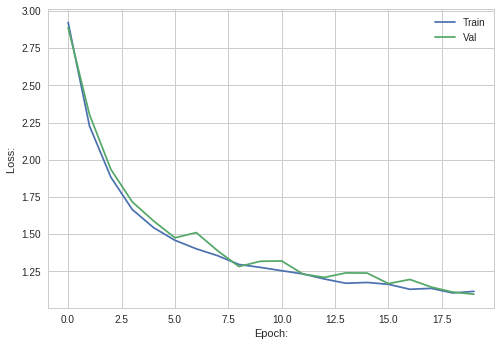

In [0]:
model = Sequential()
model.add(convol2D_1)
model.add(convol2D_2)
model.add(max_pooling)
model.add(dropout_1)
model.add(flatten)
model.add(dropout_2)
model.add(dense_1)
model.add(dense_2)

model.compile(loss = 'cross_entropy')

batch_size = 20
epochs = 20

model.fit(
      X_train_norm[0:10000], 
      y_train_norm[0:10000],
      batch_size = batch_size,
      num_epoch = epochs,
      validation_data = (X_test_norm[0:20], y_test_norm[0:20])
)

In [0]:
convol2D_1.save_weights('convol2D_1')
convol2D_2.save_weights('convol2D_2')
dense_1.save_weights('dense_1')
dense_2.save_weights('dense_2')

In [0]:
predicted = model.predict_class(X_test_norm[0:200])
target =  y_test[0:200]

In [0]:
print("Accuracy: ",accuracy_score(predicted, target))
from sklearn import metrics
print(metrics.classification_report(target, predicted))

Accuracy:  0.75
             precision    recall  f1-score   support

          0       0.94      1.00      0.97        17
          1       0.92      0.79      0.85        28
          2       0.67      0.62      0.65        16
          3       0.65      0.81      0.72        16
          4       0.79      0.82      0.81        28
          5       0.81      0.65      0.72        20
          6       0.79      0.75      0.77        20
          7       0.89      0.67      0.76        24
          8       0.40      1.00      0.57        10
          9       0.69      0.52      0.59        21

avg / total       0.78      0.75      0.75       200



Tiếp tục train thêm 10 epoch

Epoch  0 - Training loss:  1.10790770405805  - Validating loss:  1.155222209115932
Epoch  1 - Training loss:  1.09282723283647  - Validating loss:  1.162309162119335
Epoch  2 - Training loss:  1.08585056518316  - Validating loss:  1.1040841597355642
Epoch  3 - Training loss:  1.09057195790592  - Validating loss:  1.1486624710842532
Epoch  4 - Training loss:  1.07138561907188  - Validating loss:  1.0252644052066695
Epoch  5 - Training loss:  1.06766938472369  - Validating loss:  1.0321799405416445
Epoch  6 - Training loss:  1.06629894387216  - Validating loss:  1.0709090977270928
Epoch  7 - Training loss:  1.0532231673278  - Validating loss:  1.0111623533597647
Epoch  8 - Training loss:  1.04554922811798  - Validating loss:  1.0543915088628302
Epoch  9 - Training loss:  1.05152575009738  - Validating loss:  1.0411727615378026


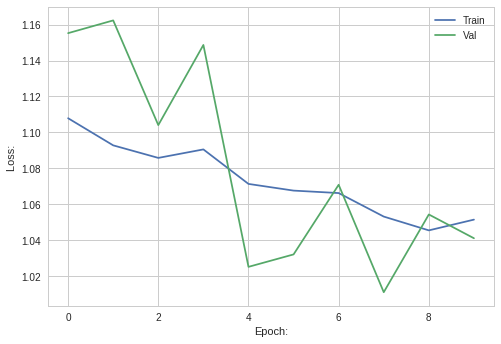

In [0]:
batch_size = 20
epochs = 10

model.fit(
      X_train_norm[0:10000], 
      y_train_norm[0:10000],
      batch_size = batch_size,
      num_epoch = epochs,
      validation_data = (X_test_norm[0:20], y_test_norm[0:20])
)

In [0]:
convol2D_1.save_weights('convol2D_1')
convol2D_2.save_weights('convol2D_2')
dense_1.save_weights('dense_1')
dense_2.save_weights('dense_2')

In [0]:
predicted = model.predict_class(X_test_norm[200:400])
target =  y_test[200:400]
print("Accuracy: ",accuracy_score(predicted, target))
from sklearn import metrics
print(metrics.classification_report(target, predicted))

Accuracy:  0.77
             precision    recall  f1-score   support

          0       0.89      1.00      0.94        16
          1       0.82      0.93      0.87        29
          2       0.92      0.79      0.85        28
          3       0.68      0.79      0.73        19
          4       0.72      0.72      0.72        18
          5       0.67      0.55      0.60        22
          6       0.82      0.64      0.72        14
          7       0.77      0.59      0.67        17
          8       0.65      0.88      0.75        17
          9       0.75      0.75      0.75        20

avg / total       0.77      0.77      0.77       200

